# ISLR- Python: Ch5 -- Lab: Resampling Methods

- [Load Datasets](#Load-Datasets)
- [5.3.1 The Validation Set Approach](#5.3.1-The-Validation-Set-Approach)
- [5.3.2 Leave-One-Out Cross Validation](#5.3.2-Leave-One-Out-Cross-Validation)
- [5.3.3 k-Fold Cross Validation](#5.3.3-k-Fold-Cross-Validation)
- [5.3.4 The Bootstrap](#5.3.4-The-Bootstrap)

In [1]:
# perform standard imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy
import scikits.bootstrap as bootstrap

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

# Load Datasets

In [2]:
# load auto dataset, note before we have found that horsepower column contains ? values we convert to nans
auto = pd.read_csv('../../data/Auto.csv',na_values='?')
auto = auto.dropna()
print(len(auto), 'Rows')
auto.head()

392 Rows


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15,8,350,165,3693,11.5,70,1,buick skylark 320
2,18,8,318,150,3436,11.0,70,1,plymouth satellite
3,16,8,304,150,3433,12.0,70,1,amc rebel sst
4,17,8,302,140,3449,10.5,70,1,ford torino


In [3]:
# load the portfolio data set
portfolio = pd.read_csv('../../data/Portfolio.csv', index_col=0)
print('\n',len(portfolio),'Rows')
portfolio.head()


 100 Rows


,X,Y
1,-0.895251,-0.234924
2,-1.562454,-0.885176
3,-0.417090,0.271888
4,1.044356,-0.734198
5,-0.315568,0.841983


## 5.3.1 The Validation Set Approach

In [4]:
# We want to predict the mpg from the horsepower. In chapter 3 we saw that the linear fit wan inadequate and so 
# we began fitting higher order polynomials. Here we will use validation approaches to examine the test MSE for 
# higher order models.

# Set the random seed so we always get the same results
np.random.seed(0)

# Split the Data #
##################
# make a boolean mask to select data from dataframe. 
training = np.random.choice([False, True], size=392)
# training set
y_train = auto.mpg[training]
x_train = sm.add_constant(auto.horsepower[training])
# validation set
y_test = auto.mpg[~training]
x_test = sm.add_constant(auto.horsepower[~training])

# Fit a Linear Model and Evaluate MSE #
#######################################
linear_model = sm.OLS(y_train, x_train)
linear_results = linear_model.fit()

# Use model on the validation set
y_predictions = linear_results.predict(x_test)

# Compute Linear Model MSE
print('Linear Model MSE = ', np.mean((y_test.values-y_predictions)**2))

# Fit a Quadratic Model and Evaluate MSE #
##########################################
# add the quadratic term to the design matrix
x_train = sm.add_constant(np.column_stack((auto.horsepower[training], auto.horsepower[training]**2)))
x_test = sm.add_constant(np.column_stack((auto.horsepower[~training], auto.horsepower[~training]**2)))

# make the model and fit
quad_model = sm.OLS(y_train, x_train)
quad_model_results = quad_model.fit()

# use the model on the validation set

y_predictions = quad_model_results.predict(x_test)

print('\nQuadratic Model MSE = ', np.mean((y_test.values-y_predictions)**2))

# Fit a Cubic Model and Evaluate MSE #
######################################
# add the cubic term to the design matrix
x_train = sm.add_constant(np.column_stack((auto.horsepower[training], auto.horsepower[training]**2, 
                                           auto.horsepower[training]**3 )))
x_test = sm.add_constant(np.column_stack((auto.horsepower[~training], auto.horsepower[~training]**2,
                                          auto.horsepower[~training]**3)))

# make the model and fit
cube_model = sm.OLS(y_train, x_train)
cube_model_results = cube_model.fit()

# use the model on the validation set

y_predictions = cube_model_results.predict(x_test)

print('\nCubic Model MSE = ', np.mean((y_test.values-y_predictions)**2))

Linear Model MSE =  20.8574348002

Quadratic Model MSE =  16.4569283724

Cubic Model MSE =  16.4427014237


## 5.3.2 Leave-One-Out Cross Validation

In the above validation approach, it was easy to use the statsmodels api to construct models and then calculate the MSE using the validation set approach. However, statsmodels does not have direct support for cross-validations i.e. LOOCV or K-fold. Instead they port the sklearn cross_val class. We will use that class directly here. 

Coefficients: Intercept, Beta(s) 39.9358610212 [-0.1578]
Coefficients: Intercept, Beta(s) 56.9000997021 [-0.4662  0.0012]
Coefficients: Intercept, Beta(s) 60.6847849067 [ -5.6885e-01   2.0790e-03  -2.1466e-06]
Coefficients: Intercept, Beta(s) 47.5676772327 [ -7.6672e-02  -4.3446e-03   3.2451e-05  -6.5304e-08]
Coefficients: Intercept, Beta(s) -32.230559918 [  3.7001e+00  -7.1424e-02   5.9311e-04  -2.2811e-06   3.3296e-09]

The estimated test MSEs =  [ 24.2315  19.2482  19.335   19.4244  19.0332]


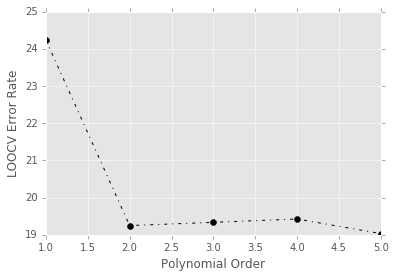

In [13]:
# Create design matrix and Responses #
######################################
X = auto.horsepower.values
X = X[:,np.newaxis]
y = auto.mpg.values

# Perform LOOCV for 5 Polynomial Models #
#########################################
# We will create models of order 1 through 5, fit and perform LOOCV

# create arrays for polnomial order and error estimates
orders = np.arange(1,6)
mse_est = np.array([])

for index, order in enumerate(orders):
    # create a polynomial of degree order, don't add bias, LinearRegression does so below
    poly = PolynomialFeatures(degree=order,interaction_only=False, include_bias=False)
        
    # create a linear model and Fit
    regress = LinearRegression()
    regress.fit(poly.fit_transform(X),y)
        
    # print the coeffecients
    print('Coefficients: Intercept, Beta(s)', regress.intercept_, regress.coef_)
        
    # Evaluate the model using Leave-one-out cross-validation (cv = len(X)) to get the MSE estimate
    mse_est = np.append(mse_est, -np.mean(cross_validation.cross_val_score(regress, poly.fit_transform(X), y, 
                                                               scoring='mean_squared_error', cv=len(X))))
    
# In the above line we negated the score results. This was a poor choice in sklearn see:
# https://github.com/scikit-learn/scikit-learn/issues/2439 for details

# print the estimated test MSEs for each model
print('\nThe estimated test MSEs = ', mse_est)
# plt the estimate 
fig , ax = plt.subplots(figsize=(6,4))
ax.plot(orders,mse_est,linestyle = '-.', marker='o',color='k');
ax.set_xlabel('Polynomial Order');
ax.set_ylabel('LOOCV Error Rate');

## 5.3.3 k-Fold Cross Validation

 We simply copy the lines of code above using 10 folds instead of n folds in the cross-validation to be explicit.

Coefficients: Intercept, Beta(s) 39.9358610212 [-0.1578]
Coefficients: Intercept, Beta(s) 56.9000997021 [-0.4662  0.0012]
Coefficients: Intercept, Beta(s) 60.6847849067 [ -5.6885e-01   2.0790e-03  -2.1466e-06]
Coefficients: Intercept, Beta(s) 47.5676772327 [ -7.6672e-02  -4.3446e-03   3.2451e-05  -6.5304e-08]
Coefficients: Intercept, Beta(s) -32.230559918 [  3.7001e+00  -7.1424e-02   5.9311e-04  -2.2811e-06   3.3296e-09]

The estimated test MSEs =  [ 27.4399  21.2358  21.3366  21.3539  20.9056]


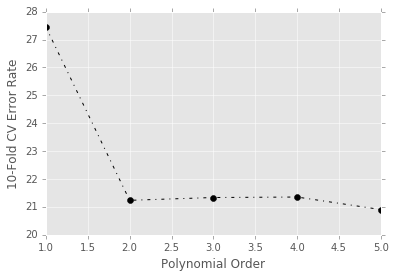

In [14]:
# Perform k-Fold CV for 5 Polynomial Models #
#############################################
# We will create models of order 1 through 5, fit and perform k-Fold CV

# create arrays for polnomial order and error estimates
orders = np.arange(1,6)
mse_est = np.array([])

for index, order in enumerate(orders):
    # create a polynomial of degree order
    poly = PolynomialFeatures(degree=order,interaction_only=False, include_bias=False)
        
    # create a linear model and Fit
    regress = LinearRegression()
    regress.fit(poly.fit_transform(X),y)
        
    # print the coeffecients
    print('Coefficients: Intercept, Beta(s)', regress.intercept_, regress.coef_)
        
    # Evaluate the model using 10-fold cross-validation (cv = 10) to get the MSE estimate
    mse_est = np.append(mse_est, -np.mean(cross_validation.cross_val_score(regress, poly.fit_transform(X), y, 
                                                               scoring='mean_squared_error', cv=10)))
    
# In the above line we negated the score results. This was a poor choice in sklearn see:
# https://github.com/scikit-learn/scikit-learn/issues/2439 for details

# print the estimated test MSEs for each model
print('\nThe estimated test MSEs = ', mse_est)
# plt the estimate 
fig , ax = plt.subplots(figsize=(6,4))
ax.plot(orders,mse_est,linestyle = '-.', marker='o',color='k');
ax.set_xlabel('Polynomial Order');
ax.set_ylabel('10-Fold CV Error Rate');

## 5.3.4 The Bootstrap

In [7]:
# We first need a function aplha to return the alpha statistic eqn. 5.7 in the text
def alpha(df, num_samples=100):
    """ 
    Returns the alpha statistic for num_saples of elements from dataframe df.
    """
    # make a num_samples random choice of indices WITH REPLACEMENT
    indices = np.random.choice(df.index, num_samples, replace=True)
    # Get X,Y
    X = df.X[indices].values
    Y = df.Y[indices].values
    
    # np.cov returns full cov matrix we need [0][1] cov(x,y)
    return (np.var(Y) - np.cov(X,Y)[0][1])/(np.var(X) + np.var(Y) - 2*np.cov(X,Y)[0][1])

# test it out,
np.random.seed(0)
print(alpha(portfolio))

0.560336658007


In [8]:
# Scikits.bootstrap has a bootstrap method for computing the confidence intervals of an estimated statistic but we 
# would need to calculate the SE. It's just as easy to write a quick function to compute the SE directly.
def boot(data, statsfunc, num_bootstrap_samples=1000):
    """
    Returns the SE of the statistic returned by statsfunc when applied to data using num_bootstrap samples.
    """
    stat_samples = []
    for sample in range(num_bootstrap_samples):
        # apply our stats_func to generate a sample statistic
        stat_samples.append(statsfunc(data))
    # compute the std of the statistic samples
    se_estimate = scipy.std(stat_samples,axis=0)
    
    print('\nBootstrapped Std. Error(s) =', se_estimate)

np.random.seed(0)
boot(portfolio, alpha, 1000)



Bootstrapped Std. Error(s) = 0.089804091613


In Chapter 3, we fit a linear model for the MPG of an automobile as a function of horsepower. Statsmodels ouptput the std error of the coeffecients $\beta_0$ and $\beta_1$ using formula 3.8 which uses estimates of the variance via the RSE (see page 66). We will now compare these coeffecient standard errors with the bootstrap estimates of the coeffecient standard errors. 

In [9]:
# Create Design Matrix and Response #
#####################################
X = sm.add_constant(auto.horsepower)
y = auto.mpg

# Create a Linear Model and Fit #
#################################
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

# Create Func to Generate Coeffecients #
########################################
# we create a function that returns a sample set of coeffecients for a sample fit
def auto_coeffs(data, num_samples=392):
    """
    Returns a set of fit coeffecients for the model mpg ~ horsepower using num_samples of data with replacement 
    """
    indices = np.random.choice(data.index, num_samples, replace=True)
    X = sm.add_constant(data.horsepower[indices])
    y = data.mpg[indices]
    
    results = sm.OLS(y,X).fit()
    
    return results.params
    
# test it out
np.random.seed(0)
print('\nA sample bootstrap estimate:\n ',auto_coeffs(auto))

# Compare Estimated Standard Errors #
#####################################
# Above we fit a model and used Eqn. 3.8 to compute the SE. Lets see what the bootstrap estimate of SE returns...

# call our boot function from above which prints out the bootstrapped standard errors
boot(auto, auto_coeffs, num_bootstrap_samples=1000)

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 28 Jul 2016   Prob (F-statistic):           7.03e-81
Time:                        17:06:07   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

Notice that the standard errors computed by statsmodels are not exactly the same as the bootstrapped standard errors. Remember that the formulas, 3.8 in text, requires estimating the variance $\sigma^2$ as $\frac{RSS}{n-2}$. The bootstrap estimates do not make any assumptions about the data and are likely closer to true SE.